# Notebook for testing how distortions change in Normalizing Flows

In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, create_latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay
from GAN_utils import GAN_Input

Using device cuda:0


In [3]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"


In [5]:
class NormalizingFlow_edit(nn.Module):
    """
    Normalizing Flow model to approximate target distribution
    """

    def __init__(self, q0, flows, p=None):
        """Constructor

        Args:
          q0: Base distribution
          flows: List of flows
          p: Target distribution
        """
        super().__init__()
        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def forward(self, z):
        """Transforms latent variable z to the flow variable x

        Args:
          z: Batch in the latent space

        Returns:
          Batch in the space of the target distribution
        """
        for flow in self.flows:
            z, _ = flow(z)
        return z

    def forward_and_log_det(self, z):
        """Transforms latent variable z to the flow variable x and
        computes log determinant of the Jacobian

        Args:
          z: Batch in the latent space

        Returns:
          Batch in the space of the target distribution,
          log determinant of the Jacobian
        """
        log_det = torch.zeros(len(z), device=z.device)
        for flow in self.flows:
            z, log_d = flow(z)
            log_det += log_d
        return z, log_det

    def inverse(self, x):
        """Transforms flow variable x to the latent variable z

        Args:
          x: Batch in the space of the target distribution

        Returns:
          Batch in the latent space
        """
        for i in range(len(self.flows) - 1, -1, -1):
            x, _ = self.flows[i].inverse(x)
        return x

    def inverse_and_log_det(self, x):
        """Transforms flow variable x to the latent variable z and
        computes log determinant of the Jacobian

        Args:
          x: Batch in the space of the target distribution

        Returns:
          Batch in the latent space, log determinant of the
          Jacobian
        """
        log_det = torch.zeros(len(x), device=x.device)
        for i in range(len(self.flows) - 1, -1, -1):
            x, log_d = self.flows[i].inverse(x)
            log_det += log_d
        return x, log_det

    def forward_kld(self, x):
        """Estimates forward KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)

        Args:
          x: Batch sampled from target distribution

        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)
    def forward_kld_no_mean(self, x):
        """Estimates forward KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)

        Args:
          x: Batch sampled from target distribution

        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -log_q

    def reverse_kld(self, num_samples=1, beta=1.0, score_fn=True):
        """Estimates reverse KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)

        Args:
          num_samples: Number of samples to draw from base distribution
          beta: Annealing parameter, see [arXiv 1505.05770](https://arxiv.org/abs/1505.05770)
          score_fn: Flag whether to include score function in gradient, see [arXiv 1703.09194](https://arxiv.org/abs/1703.09194)

        Returns:
          Estimate of the reverse KL divergence averaged over latent samples
        """
        z, log_q_ = self.q0(num_samples)
        log_q = torch.zeros_like(log_q_)
        log_q += log_q_
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        if not score_fn:
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)

    def reverse_alpha_div(self, num_samples=1, alpha=1, dreg=False):
        """Alpha divergence when sampling from q

        Args:
          num_samples: Number of samples to draw
          dreg: Flag whether to use Double Reparametrized Gradient estimator, see [arXiv 1810.04152](https://arxiv.org/abs/1810.04152)

        Returns:
          Alpha divergence
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        log_p = self.p.log_prob(z)
        if dreg:
            w_const = torch.exp(log_p - log_q).detach()
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
            w = torch.exp(log_p - log_q)
            w_alpha = w_const**alpha
            w_alpha = w_alpha / torch.mean(w_alpha)
            weights = (1 - alpha) * w_alpha + alpha * w_alpha**2
            loss = -alpha * torch.mean(weights * torch.log(w))
        else:
            loss = np.sign(alpha - 1) * torch.logsumexp(alpha * (log_p - log_q), 0)
        return loss

    def sample(self, num_samples=1):
        """Samples from flow-based approximate distribution

        Args:
          num_samples: Number of samples to draw

        Returns:
          Samples, log probability
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        """Get log probability for batch

        Args:
          x: Batch

        Returns:
          log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        """Save state dict of model

        Args:
          path: Path including filename where to save model
        """
        torch.save(self.state_dict(), path)

    def load(self, path):
        """Load model from state dict

        Args:
          path: Path including filename where to load model from
        """
        self.load_state_dict(torch.load(path))

In [6]:
num_samples = 100
MC_Graphs = GraphDataset(prefix+MCdataset)

#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [7]:
num_signal = 62532
num_total = 141118
num_bg = num_total - num_signal
#All signal events are after the 78586 index, consecutive

In [8]:
distorted_inputs = GAN_Input(MC_Graphs, distortion_range = (-0.02,0.02), shuffle = False)
inputs = GAN_Input(MC_Graphs, distort = False, shuffle = False)
bg_inputs = GAN_Input(MC_Graphs, distort = False, shuffle = False)
signal_inputs = GAN_Input(MC_Graphs, distort = False, shuffle = False)

In [9]:
bg_tensor = torch.empty(num_bg,6)
signal_tensor = torch.empty(num_signal,6)
for i in range(num_total):
    if(i < num_bg):
        bg_tensor[i] = inputs.data[i]
    else:
        signal_tensor[i - num_bg] = inputs.data[i]

In [10]:
bg_inputs.change_input(torch.clone(bg_tensor))
signal_inputs.change_input(torch.clone(signal_tensor))

In [11]:
def get_masked_affine(num_layers = 32, latent_dim = 71, hidden_dim = 142):
    #mask
    b = torch.ones(latent_dim)
    for i in range(b.size()[0]):
        if i % 2 == 0:
            b[i] = 0
    masked_affine_flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([latent_dim, hidden_dim, hidden_dim, latent_dim])
        t = nf.nets.MLP([latent_dim, hidden_dim,hidden_dim, latent_dim])
        if i % 2 == 0:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    return masked_affine_flows

In [12]:
# SETTING UP DATA MODEL

masked_affine_flows_train_bg = get_masked_affine(latent_dim = 6, hidden_dim = 20)
distribution_bg = nf.distributions.DiagGaussian(bg_inputs.num_features, trainable = False)
masked_affine_model_bg = NormalizingFlow_edit(q0=distribution_bg, flows=masked_affine_flows_train_bg)
bg_model = masked_affine_model_bg.to(device)

In [13]:
# SETTING UP MC MODEL

masked_affine_flows_train_signal = get_masked_affine(latent_dim = 6,hidden_dim = 20)
distribution_signal = nf.distributions.DiagGaussian(signal_inputs.num_features, trainable = False)
masked_affine_model_signal = NormalizingFlow_edit(q0=distribution_signal, flows=masked_affine_flows_train_signal)
signal_model = masked_affine_model_signal.to(device)

  0%|          | 0/625 [00:35<?, ?it/s]


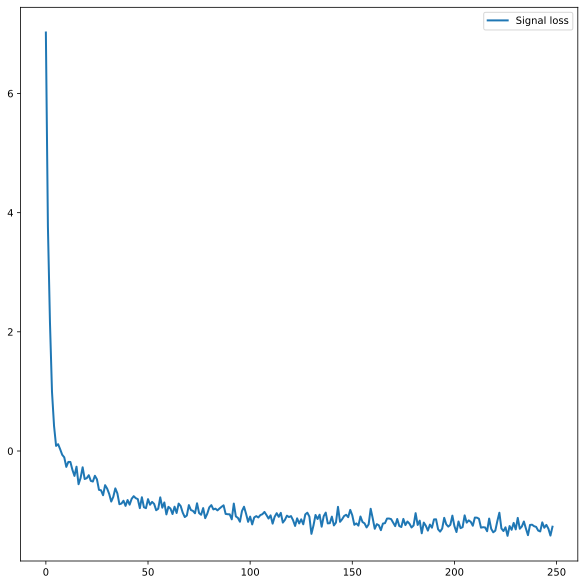

Lowest Loss: -1.4234997630119324


In [14]:
# TRAINING MC
signal_loss, signal_full_loss = train(signal_inputs, signal_model, distorted = False, num_epochs = 4,compact_num = 10)
plot_loss(signal_loss, label = "Signal loss")

  0%|          | 0/785 [00:49<?, ?it/s]


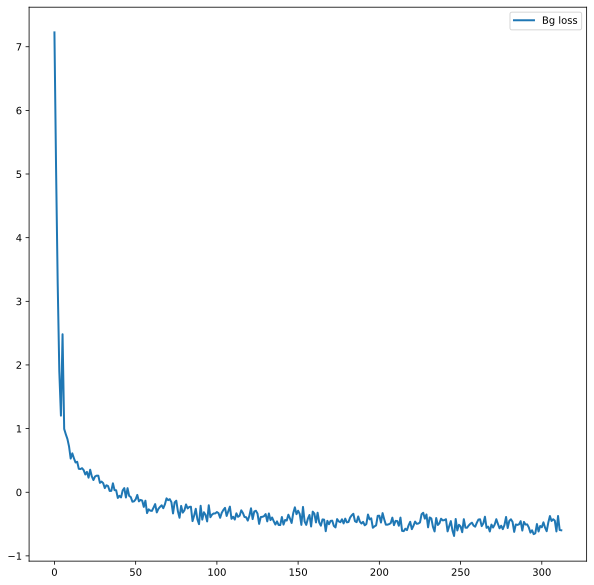

Lowest Loss: -0.6869342207908631


In [15]:
# TRAINING Distorted
bg_loss, bg_full_loss = train(bg_inputs, bg_model, distorted = False, num_epochs = 4, compact_num = 10)
plot_loss(bg_loss, label = "Bg loss")

# Testing

In [36]:
#bg and signal in their respective models
test(bg_inputs, bg_model)
test(signal_inputs, signal_model)

100%|██████████| 785/785 [00:11<00:00, 70.62it/s]


average loss: -0.5629947781562805


100%|██████████| 625/625 [00:08<00:00, 72.32it/s]

average loss: -1.3049362897872925


In [37]:
# Now trying on each other's models
test(signal_inputs, bg_model)
test(bg_inputs, signal_model)

100%|██████████| 625/625 [00:08<00:00, 73.16it/s]


average loss: -0.9229193329811096


100%|██████████| 785/785 [00:10<00:00, 71.78it/s]

average loss: 1.326057414461805e+29


# FINISH THIS

In [60]:
def get_nll(in_data, model):
    data_tensor = torch.empty(in_data.data.size()[0])
    model.eval()
    with torch.no_grad():
        for it in tqdm(range(in_data.max_iter), position = 0, leave=True):
            test_samples = in_data.sample(iteration = it)
            test_samples = test_samples.to(device)
            output_batch = model.forward_kld_no_mean(test_samples)
#             print(output_batch.size())
            for i in range(in_data.batch_size):
                data_tensor[it*in_data.batch_size + i] = output_batch[i]
#     print(data_tensor.size())
    return data_tensor

def get_predictions(in_data, signal_model, bg_model, signal_cut, bg_cut):
    print(f"Calculating signal nll")
    signal_probs = get_nll(in_data, signal_model)
#     print(signal_probs.size())
    print(f"Calculating bg nll")
    bg_probs = get_nll(in_data, bg_model)
    predictions = torch.empty(in_data.data.size()[0])
    for i in range(len(signal_probs)):
        if((signal_probs[i] > signal_cut) and (bg_probs[i] > bg_cut)):
            predictions[i] = 0
        else:
            predictions[i] = 1
    return predictions

def test_NF_Classifier(in_data, signal_model, bg_model, labels, signal_cut,bg_cut):
    predictions = get_predictions(in_data, signal_model, bg_model,signal_cut,bg_cut)
    test_acc = (predictions == labels).sum().item() / len(predictions)
    print(f"Accuracy = {test_acc}")
    return test_acc

In [61]:
input_labels = MC_Graphs.labels[:,0]


Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 69.84it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:20<00:00, 69.06it/s]


Accuracy = 0.5484984197621848
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 69.83it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:21<00:00, 66.51it/s]


Accuracy = 0.5530265451607874
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 69.45it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:19<00:00, 71.28it/s]


Accuracy = 0.5578806388979436
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 69.02it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:19<00:00, 71.91it/s]


Accuracy = 0.5507801981320597
Calculating signal nll


100%|██████████| 1411/1411 [00:19<00:00, 71.73it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:21<00:00, 66.46it/s]


Accuracy = 0.5548264572910614
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 67.27it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:19<00:00, 73.21it/s]


Accuracy = 0.5591349083745518
Calculating signal nll


100%|██████████| 1411/1411 [00:19<00:00, 74.01it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:20<00:00, 68.56it/s]


Accuracy = 0.5502203829419351
Calculating signal nll


100%|██████████| 1411/1411 [00:21<00:00, 67.14it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:21<00:00, 66.75it/s]


Accuracy = 0.553536756473306
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 68.20it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:21<00:00, 65.38it/s]


Accuracy = 0.5570798905880185
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 67.85it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:20<00:00, 67.42it/s]


Accuracy = 0.5485905412491674
Calculating signal nll


100%|██████████| 1411/1411 [00:20<00:00, 69.19it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:20<00:00, 67.55it/s]


Accuracy = 0.5511841154211369
Calculating signal nll


100%|██████████| 1411/1411 [00:19<00:00, 71.39it/s]


Calculating bg nll


100%|██████████| 1411/1411 [00:18<00:00, 74.66it/s]


Accuracy = 0.553820207202483


ValueError: x and y must be the same size

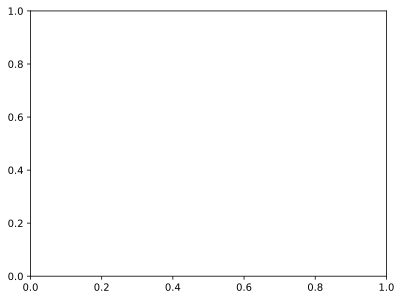

In [62]:
accs = np.array([])
signal_cuts = np.linspace(-1, 0, 4)
bg_cuts = np.linspace(-0.75, -1, 3)
for i in signal_cuts:
    for j in bg_cuts:
        acc = test_NF_Classifier(inputs, signal_model, bg_model, input_labels,i,j)
        accs = np.append(accs,acc)
    
plt.scatter(cuts, accs)

In [ ]:
x = (0.5569 *len(MC_loss) / 3)
x

In [ ]:
plt.plot(MC_loss)
x = (0.5569 *len(MC_loss) / 3)
x2 = (0.5569 *len(MC_loss) / 3) + (len(MC_loss) / 3)
x3 = (0.5569 *len(MC_loss) / 3) + (2 *(len(MC_loss) / 3))
plt.axvline(x = x, color = "r", alpha = 0.3)
plt.axvline(x = x2, color = "r", alpha = 0.3)
plt.axvline(x = x3, color = "r", alpha = 0.3)
plt.title("NF loss when MC is in order of bg then signal")
plt.savefig("plots/NF_Classifier/full_loss_w_vertical.jpeg")

# Plotting sanity checks

In [ ]:
normalized_MC = transform(inputs, MC_model)
normalized_distorted = transform(distorted_inputs, distort_model, distorted = True)

In [ ]:
normalized_distorted_obj = Latent_data(normalized_distorted, torch.empty([]))
full_pass_distorted = transform(normalized_distorted_obj, MC_model, reverse = False)

In [ ]:
def plot_6_histos(data_tensor, color,bins = 150, description = "none", save = False, save_loc = "plots/img.jpeg"):
    histos, ((h11,h12,h13),(h21,h22,h23)) = plt.subplots(2,3, figsize = (10,7))
    if description == "none":
        histos.suptitle("Several 1D Histos")
    else:
        histos.suptitle(f"Several 1D Histos {description}")
    hlist = [h11,h12,h13,h21,h22,h23]
    for i in range(len(hlist)):
        hlist[i].hist(data_tensor[:,i], bins=150,color=color, density = True);
        hlist[i].set_xlim([-1,1])
    plt.show()
    if(save):
        histos.savefig(save_loc)

In [ ]:
plot_6_histos(inputs.data,'r', description = "MC", save = True, save_loc = "plots/NF/six_hists_MC.jpeg")

In [ ]:
plot_6_histos(inputs.distorted_features,'g', description = "MC distorted", save = True, save_loc = "plots/NF/six_hists_MC_distort_0_02.jpeg")

In [ ]:
plot_6_histos(full_pass_distorted,'b', description = 'fullpass distorted', save = True, save_loc = "plots/NF/six_hists_fullpass_0_02.jpeg")